***Author: Jarod Carroll***
# Predicting Ion Switching

**Data Source: https://www.kaggle.com/c/liverpool-ion-switching/data**

## Methodology
1. Data Acquisition
    - Download and unzip file from Kaggle
2. Data Inspection
    - Figure out what is important about the data
3. Development Cycle
    - Data Preprocessing 
        - Transform the data to remove drift
        - Break the data into different waveforms
    - Modeling
        - Use a random forest model
    - Evaluation
        - Grade this model by submiting predictions to Kaggle
4. Final Development Cycle
5. Future Direction
    - Keep Optimizing Model
        - Find new ways to preprocess data
        - Use different models
        - Evaluate with macro F1 by submiting to Kaggle
    
##### Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from keras.models import load_model

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.transformers import LinearTransformation, ParabolicTransformation, TrigTransformation
from src.preprocessing import *
from src.sliding_window import *
from src.models import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Global Var
sliding_window_size = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Acquisition

The data was downloaded from Kaggle and unzipped.

### Data Inspection
In order to understand the features of this data the time series was graphed and visually inspected. First the data was loaded into dataframes and then graphed.

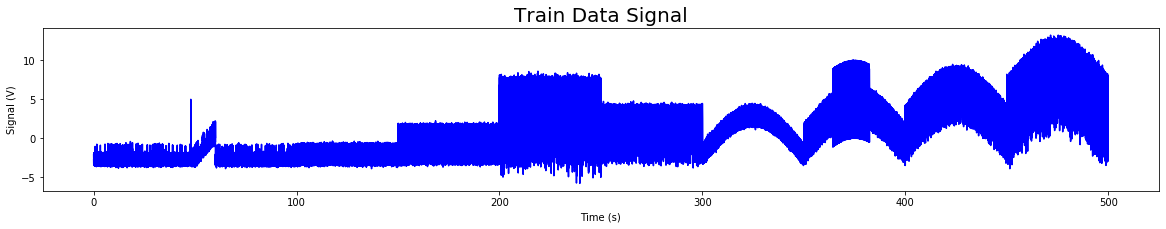

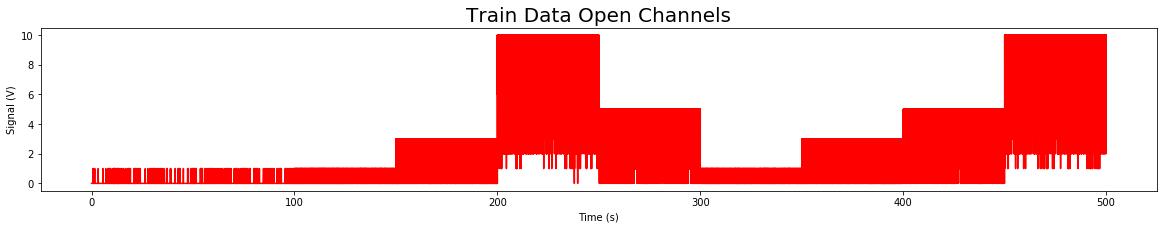

In [33]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

plt.figure(figsize = (20, 3))
plt.plot(full_data['time'], full_data['signal'], color = 'blue')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Train Data Signal", fontsize = 20)

plt.figure(figsize = (20, 3))
plt.plot(full_data['time'], full_data['open_channels'], color = 'red')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Train Data Open Channels", fontsize = 20);

Things to note:
- The data is proken up into sections 0f 500,000 data point
- The recording is 10 kHz data
- In the signal data there are 2 types of drift. Linear drift and sine drift (this was first thought to be parabolic)
- In the open channels data there are 5 different forms based on how many channels they are recording and what type they are.
    1. 1 slow ion channel
    2. 1 fast ion channel
    3. 3 ion channels
    4. 5 ion channels
    5. 10 ion channels
This data was broken into 50 second chunks because they each chunk is a different recording.

The same characteristics can be seen in the test data.

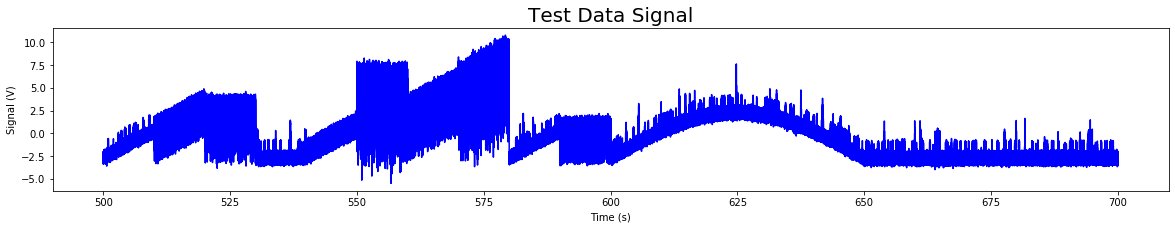

In [34]:
plt.figure(figsize = (20, 3))
plt.plot(test_data['time'], test_data['signal'], color = 'blue')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Test Data Signal", fontsize = 20);

This test data was broken into chunks by visual inspection. The delimeters for each chunk were on a 100 thousand datapoint marker making it easy to break apart.

### Development Cycle
#### Overview

One development cycle consists of 3 parts. First the raw data was preprocessed and feature engineering was done. Then the preprocessed data was then used to train a model. The last part is to evaluate the model by a Kaggle submission.

#### Data Preprocessing
During this phase of the development cycle the data was manipulated in some way. These manipulations were done in oreder to isolate the actual underlying parent function. This was done by either removing drift or transforming the data in some way.

During the first development cycle the linear drift (present at the start of the training orange data) and sine drifts were removed by subtracting the the rolling mean of the signal data from itself.

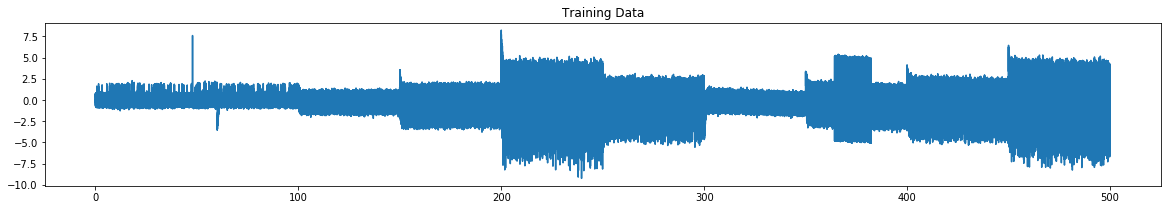

In [35]:
full_data['signal'] = full_data['signal'] - full_data['signal'].rolling(10000, min_periods = 0).mean()
plt.figure(figsize = (20, 3))
plt.title('Training Data')
plt.plot(full_data['time'], full_data['signal']);

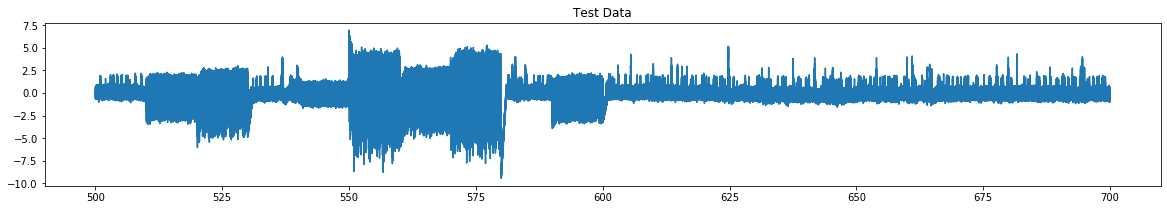

In [36]:
test_data['signal'] = test_data['signal'] - test_data['signal'].rolling(10000, min_periods = 0).mean()
plt.figure(figsize = (20, 3))
plt.title('Test Data')
plt.plot(test_data['time'], test_data['signal']);

Since it was already known that the data consisted of multiple trials of data the data was broken up into seperate sections. The train data was broken up into 500,000 datapoints (50 seconds) of data each since this was already stated about the data of Kaggle. The test data was broken into sections of 100,000 datapoints which was determined visually.

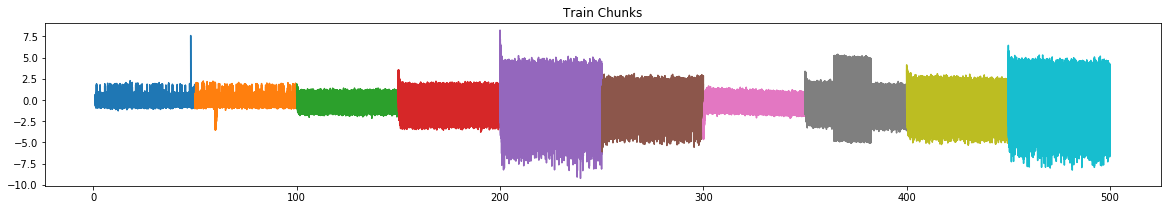

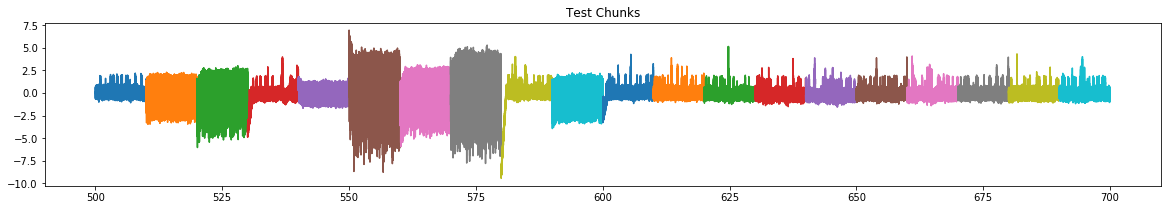

In [37]:
plt.figure(figsize = (20, 3))
plt.title('Train Chunks')
train_data_chunks = chunk_data(full_data, 10)
for chunk in full_data_chunks:
    plt.plot(chunk['time'], chunk['signal'])
    
plt.figure(figsize = (20, 3))
plt.title('Test Chunks')
test_data_chunks = chunk_data(test_data, 20)
for chunk in test_data_chunks:
    plt.plot(chunk['time'], chunk['signal'])

When a new development cycle started the preprocessing was either done the same as a previous cycle or a new way was tried

#### Modeling

During the modeling process a model was applied to each of the 5 distinct waveforms. Each of the models were trained on their assigned waveform and were then assigned to their coresponding test waveform. 

During the first development cycle, a random forest was used for each of the waveforms. First similar waveforms were grouped together.

In [38]:
model1_data = pd.concat([train_data_chunks[0], train_data_chunks[1]])
model2_data = pd.concat([train_data_chunks[2], train_data_chunks[6]])
model3_data = pd.concat([train_data_chunks[3], train_data_chunks[7]])
model4_data = pd.concat([train_data_chunks[5], train_data_chunks[8]])
model5_data = pd.concat([train_data_chunks[4], train_data_chunks[9]])

Then models were trained on these groups.

In [40]:
model1 = RandomForestRegressor(n_estimators = 10).fit(pd.DataFrame(model1_data['signal']), model1_data['open_channels'])
model2 = RandomForestRegressor(n_estimators = 10).fit(pd.DataFrame(model2_data['signal']), model2_data['open_channels'])
model3 = RandomForestRegressor(n_estimators = 10).fit(pd.DataFrame(model3_data['signal']), model3_data['open_channels'])
model4 = RandomForestRegressor(n_estimators = 10).fit(pd.DataFrame(model4_data['signal']), model4_data['open_channels'])
model5 = RandomForestRegressor(n_estimators = 10).fit(pd.DataFrame(model5_data['signal']), model5_data['open_channels'])

#### Evaluation
The models were used to draw predictions on the test data and these predictions were submited to Kaggle to get an F1 score. This marks whether or not the development cycle was succesful in improving the models.

In [42]:
def predict(model, test_data):
    y_predictions = [int(round(prediction)) for prediction in model.predict(pd.DataFrame(test_data['signal']))]
    return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})

predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_data_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_data_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_data_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_data_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_data_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_data_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_data_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_data_chunks[19])])

predictions.to_csv('~/Desktop/test_predictions.csv', index = False, float_format='%.4f')

### Final Development Cycle

Using the information gained from each itteration the data was now transformed by subtracting off a function from the data. These functions were either a linear function, sine function or nothing.

In [5]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

train_chunks = chunk_data(full_data, 10)
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

train_chunks = transform_train_chunks(train_chunks)
test_chunks = transform_test_chunks(test_chunks);

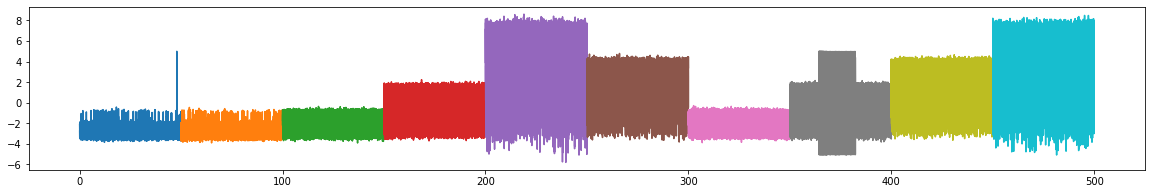

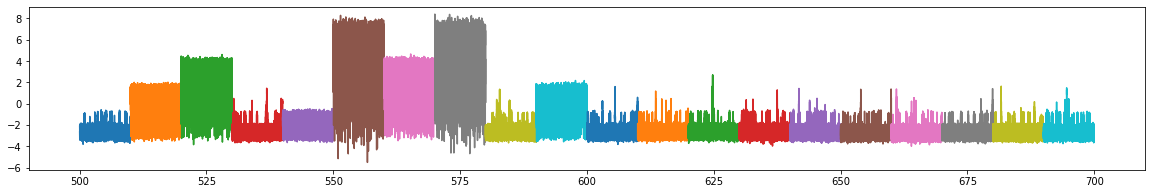

In [6]:
plt.figure(figsize = (20, 3))
for chunk in train_chunks:
    plt.plot(chunk['time'], chunk['signal'])
    
plt.figure(figsize = (20, 3))
for chunk in test_chunks:
    plt.plot(chunk['time'], chunk['signal'])

#### Final Modeling
In order to improve this model to a 0.94 a neural network was used. Once tuned these models were saved for future predictions

In [10]:
model1 = load_model('../../data/models/NN_model1.h5')
model2 = load_model('../../data/models/NN_model2.h5')
model3 = load_model('../../data/models/NN_model3.h5')
model4 = load_model('../../data/models/NN_model4.h5')
model5 = load_model('../../data/models/NN_model5.h5')

In [16]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_chunks[19])])

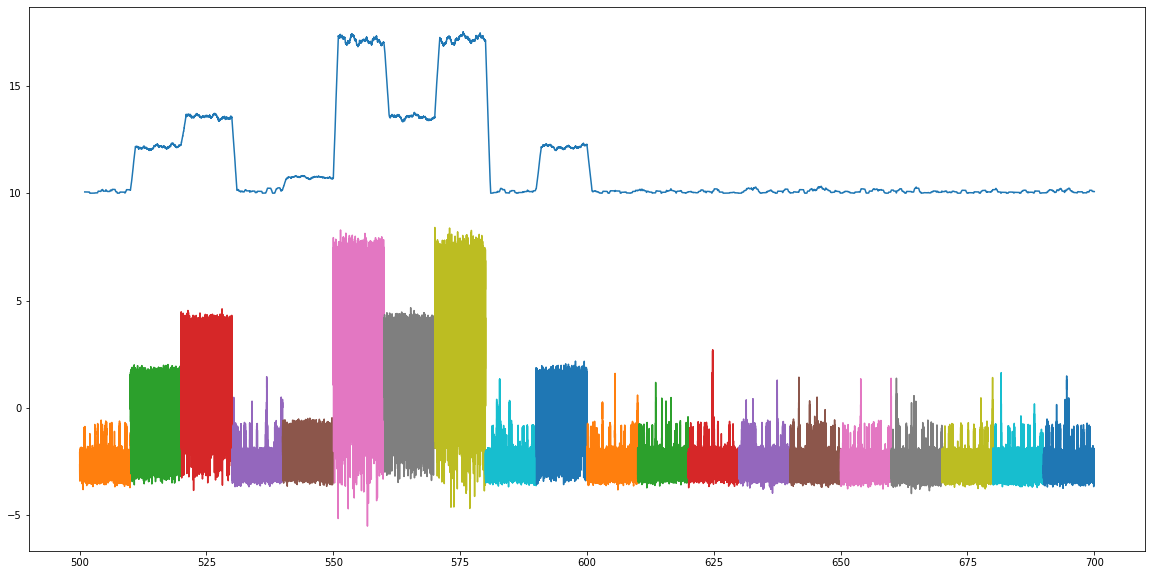

In [17]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

### Future Direction
Improve the model by transforming the data in different ways or by reconfiguring the neural network.

It was also be great to have a website where patch clamp data can be submited and predictions for the ion channels open are given back.